In [1]:
# import matplotlib.pyplot as plot
from matplotlib import pyplot as plt
import numpy as np
import math 

import pandas as pd
import scipy.io
import mat73
import math 
import pickle 
import random 

from scipy.ndimage import gaussian_filter
from scipy import ndimage
from scipy import signal
# from matplotlib.pyplot import figure


In [2]:
##  GET INDICES OF SPECIFIC TRIALS. WE CAN USE THESE INDICES LATER TO GET POKEIN ETC OF THE TRIALS WE ARE INTERESTED IN 

## use indices during all odor a,b,c,d presentations, and not just trials when all are inseq: 
## select only correct inseq trials:

def get_inseq_odors_local(pretrialbehav):

    x = np.transpose(pretrialbehav['Odor'])
    idx_1 = [i for i in range(0,len(x)) if int(x[i])== 1 ]
    idx_2 = [i for i in range(0,len(x)) if int(x[i])== 2 ]
    idx_3 = [i for i in range(0,len(x)) if int(x[i])== 3 ]
    idx_4 = [i for i in range(0,len(x)) if int(x[i])== 4 ]
    idx_5 = [i for i in range(0,len(x)) if int(x[i])== 5 ]

    all_trials = {}
    key_list = ["1","2","3","4","5"]
    value_list = [idx_1,idx_2,idx_3,idx_4,idx_5]

    #get pairs of elements: 
    zip_iterator = zip(key_list,value_list)
    all_trials = dict(zip_iterator)


    for k,v in all_trials.items():
        idx = all_trials[k]
        x = np.transpose(pretrialbehav['Performance'])
        selected_performance = x[idx]
        x = np.transpose(pretrialbehav['PokeDuration']) 
        selected_durations = x[idx]
        x = np.transpose(pretrialbehav['Position'])
        selected_positions = x[idx]
        for i in range(len(idx)-1):
        # for inseq odors, check for timming erros and don't mark them as incorrect 
            if selected_performance[i] == 0 and selected_positions[i] == int(k) and selected_durations[i] > 1.05 :
                idx[i] = idx[i]
            elif selected_performance[i] == 1 and selected_positions[i] == int(k):
                idx[i] = idx[i]
            else: 
                idx[i] = np.nan 

        idx_sel = [i for i in idx if math.isnan(i) == False]
        all_trials[k] = idx_sel
        
    # get POKEIN indices 
    x = np.transpose(pretrialbehav['PokeInIndex'])
    pokein_o0 = x[all_trials['1']]
    pokein_o1 = x[all_trials['2']]
    pokein_o2 = x[all_trials['3']]
    pokein_o3 = x[all_trials['4']]
    pokein_o4 = x[all_trials['5']]

    pokein = np.concatenate([pokein_o0,pokein_o1,pokein_o2,pokein_o3,pokein_o4])

    key_list = ['1','2','3','4','5']
    value_list = [pokein_o0,pokein_o1,pokein_o2,pokein_o3,pokein_o4]
    zip_iterator = zip(key_list,value_list)
    pokein_dict = dict(zip_iterator)

    print(pokein_o0.shape)
    print(pokein_o1.shape)
    print(pokein_o2.shape)
    print(pokein_o3.shape)
    print(pokein_o4.shape)
    print(pokein.shape)


    # get pokeout 
    x = np.transpose(pretrialbehav['PokeOutIndex'])
    pokeout_o0 = x[all_trials['1']]
    pokeout_o1 = x[all_trials['2']]
    pokeout_o2 = x[all_trials['3']]
    pokeout_o3 = x[all_trials['4']]
    pokeout_o4 = x[all_trials['5']]

    pokeout = np.concatenate([pokeout_o0,pokeout_o1,pokeout_o2,pokeout_o3,pokeout_o4])

        
    return (all_trials,pokein_o0, pokein_o1,pokein_o2, pokein_o3, pokein_o4, pokeout_o0, pokeout_o1, pokeout_o2, pokeout_o3, pokeout_o4)
  

In [3]:
def get_activity_specific_odor_trials(activity,pokein_odor,inseq_duration):
    
    spikes_odor_chosen = np.zeros([inseq_duration, activity.shape[1], pokein_odor.shape[0]])
    
    for trial in range(pokein_odor.shape[0]):
        spikes_odor_chosen[:,:,trial] = activity[pokein_odor[trial][0][0][0]:pokein_odor[trial][0][0][0]+inseq_duration]
        
    return(spikes_odor_chosen)

In [50]:
# normalizing activity of each neuron - divide activity of each neuron with its highest spiking value. 
# NAN is produced because activity of some neurons is 0, and so 0/0 = nan

def normalize_activity_each_neuron(avg_activity_odor_chosen):
    normalize_activity = avg_activity_odor_chosen/np.max(avg_activity_odor_chosen,axis = 0)
#     normalize_activity[np.isnan(normalize_activity)] = 0
    
    return(normalize_activity)
    
    


In [52]:
# set NANs produced due to the inactive neurons back to 0. 
# then re-order the matrix such neuron firing at its peak earliest in the 1200 ms is indexed in the first row

def sort_neurons_mean(avg_activity):
    spike_idx_indiv = np.zeros([avg_activity.shape[1]])
    for neuron in range(avg_activity.shape[1]):
        if (np.isnan(np.sum(avg_activity[:,neuron])) == False):
            spike_idx_indiv[neuron] = np.where(avg_activity[:,neuron] ==np.max(avg_activity[:,neuron]))[0][0]
        else :
            spike_idx_indiv[neuron] = np.nan

    sorted_idx = np.argsort(spike_idx_indiv)
    sorted_activity = avg_activity[:,np.argsort(spike_idx_indiv)]
    sorted_activity[np.isnan(sorted_activity)] = 0
    
    return(sorted_idx, sorted_activity)
    
    

In [6]:
# load data 
behav_mat = scipy.io.loadmat('SuperChris_BehaviorMatrix.mat') 
ensemble_mat = mat73.loadmat('SuperChris_EnsembleMatrix.mat')
behav_info = scipy.io.loadmat('behav_info.mat') 

pretrialbehav = behav_info["preTrialBehavMatrix"]
spiking = ensemble_mat["ensembleMatrix"]  #FIRST COLUMN IS THE TIME, THE REST ARE THE ACTIVITIES OF SINGLE UNITS 


In [7]:
# get specific trials (inseq correct trials for different odors)

(all_trials,pokein_o0, pokein_o1,pokein_o2, pokein_o3, pokein_o4, pokeout_o0, pokeout_o1, pokeout_o2, pokeout_o3, pokeout_o4) = get_inseq_odors_local(pretrialbehav)

pokein = np.concatenate([pokein_o0,pokein_o1,pokein_o2,pokein_o3,pokein_o4])
key_list = ['1','2','3','4','5']
value_list = [pokein_o0,pokein_o1,pokein_o2,pokein_o3,pokein_o4]
zip_iterator = zip(key_list,value_list)
pokein_dict = dict(zip_iterator)

pokeout = np.concatenate([pokeout_o0,pokeout_o1,pokeout_o2,pokeout_o3,pokeout_o4])
key_list = ['1','2','3','4','5']
value_list = [pokeout_o0,pokeout_o1,pokeout_o2,pokeout_o3,pokeout_o4]
zip_iterator = zip(key_list,value_list)
pokeout_dict = dict(zip_iterator)


(56, 1)
(50, 1)
(40, 1)
(34, 1)
(31, 1)
(211, 1)


In [8]:
behav_mat['behavMatrixColIDs']

array([[array(['TimeBin'], dtype='<U7'), array(['Odor1'], dtype='<U5'),
        array(['Odor2'], dtype='<U5'), array(['Odor3'], dtype='<U5'),
        array(['Odor4'], dtype='<U5'), array(['Odor5'], dtype='<U5'),
        array(['Position1'], dtype='<U9'),
        array(['Position2'], dtype='<U9'),
        array(['Position3'], dtype='<U9'),
        array(['Position4'], dtype='<U9'),
        array(['Position5'], dtype='<U9'),
        array(['InSeqLog'], dtype='<U8'),
        array(['PerformanceLog'], dtype='<U14'),
        array(['PokeEvents'], dtype='<U10'),
        array(['FrontReward'], dtype='<U11'),
        array(['BackReward'], dtype='<U10'),
        array(['XvalRatMazePosition'], dtype='<U19'),
        array(['YvalRatMazePosition'], dtype='<U19')]], dtype=object)

In [9]:
## smooth the spiking using a gaussian 

sigma = 150 
gaussian_kernel = signal.windows.gaussian(sigma, std = (sigma-1)/(2*2.5))

# create a new variable which contains only spiking info. the first column in spiking is time info
spiking_only = spiking[:,1:]

spikes_gaussian = np.zeros([spiking_only.shape[0], spiking_only.shape[1]])
for neuron in range(spiking_only.shape[1]):
    spikes_gaussian[:,neuron] = np.convolve(spiking_only[:,neuron],gaussian_kernel,'same')  
    

In [53]:
# get smoothed spiking activity when specific odors are presented

inseq_duration = 1200 # duration of each trial

# activity when odor A trials are presented
spikes_odor_a = get_activity_specific_odor_trials(spikes_gaussian,pokein_o0,inseq_duration)

# activity when odor B trials are presented
spikes_odor_b = get_activity_specific_odor_trials(spikes_gaussian,pokein_o1,inseq_duration)

# activity when odor C trials are presented
spikes_odor_c = get_activity_specific_odor_trials(spikes_gaussian,pokein_o2,inseq_duration)

# activity when odor D trials are presented
spikes_odor_d = get_activity_specific_odor_trials(spikes_gaussian,pokein_o3,inseq_duration)


In [54]:
# divide activity of each neuron with its highest spiking value, and then re-order the matrix such neuron firing at its peak earliest in the 1200 ms is indexed in the first row 
# the warnings are because some neurons don't fire and so a division of 0/0 leads to the warning

# odor A
avg_activity_odor_a = np.mean(spikes_odor_a,axis = 2)
norm_activity_odor_a = normalize_activity_each_neuron(avg_activity_odor_a)
sorted_idx_odor_a, sorted_odor_a = sort_neurons_mean(norm_activity_odor_a)

# odor B
avg_activity_odor_b = np.mean(spikes_odor_b,axis = 2)
norm_activity_odor_b = normalize_activity_each_neuron(avg_activity_odor_b)
sorted_idx_odor_b, sorted_odor_b = sort_neurons_mean(norm_activity_odor_b)

# odor C
avg_activity_odor_c = np.mean(spikes_odor_c,axis = 2)
norm_activity_odor_c = normalize_activity_each_neuron(avg_activity_odor_c)
sorted_idx_odor_c, sorted_odor_c = sort_neurons_mean(norm_activity_odor_c)

# odor D
avg_activity_odor_d = np.mean(spikes_odor_d,axis = 2)
norm_activity_odor_d = normalize_activity_each_neuron(avg_activity_odor_d)
sorted_idx_odor_d, sorted_odor_d = sort_neurons_mean(norm_activity_odor_d)



C:\Users\FORTIN~1\AppData\Local\Temp/ipykernel_1636/2257334971.py:5: RuntimeWarning: invalid value encountered in true_divide
  normalize_activity = avg_activity_odor_chosen/np.max(avg_activity_odor_chosen,axis = 0)


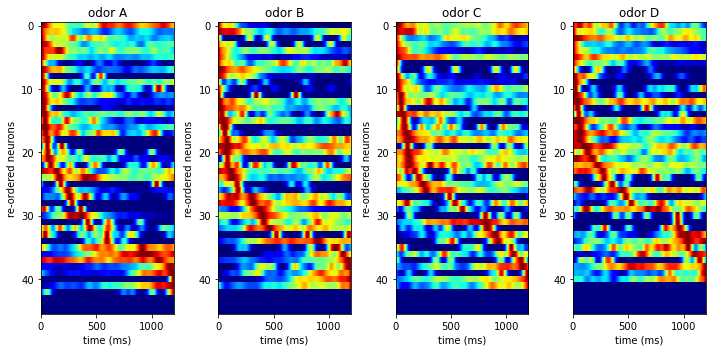

In [56]:
fig, axs = plt.subplots(1,4, figsize = (10,5))

axs[0].imshow(sorted_odor_a.T, cmap='jet', interpolation='nearest', aspect='auto')
axs[0].set_title('odor A')

axs[1].imshow(sorted_odor_b.T, cmap='jet', interpolation='nearest', aspect='auto')
axs[1].set_title('odor B')

axs[2].imshow(sorted_odor_c.T, cmap='jet', interpolation='nearest', aspect='auto')
axs[2].set_title('odor C')

im = axs[3].imshow(sorted_odor_d.T, cmap='jet', interpolation='nearest', aspect='auto')
axs[3].set_title('odor D')

for ax in axs.flat:
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('re-ordered neurons')
    
# fig.colorbar(im)

plt.tight_layout()

